# Actividad 4 · Perfilado de Datos

## Objetivo
Perfilar la calidad de un dataset real de e-commerce, limpiar nulos y duplicados, y formalizar un data contract para asegurar calidad mínima en futuros consumos.

## Conjunto de datos
- Online Retail II (UCI ML Repository): https://archive.ics.uci.edu/dataset/502/online+retail+ii
- Kaggle: https://www.kaggle.com/datasets/carrie1/ecommerce-data/data

El dataset agrupa transacciones de 2009 a 2011 de un minorista online del Reino Unido.

## Entregable
Notebook “W2.1 Perfilado y Limpieza de Datos” en `Notebooks/Homework/`, con todas las celdas ejecutadas y salidas visibles.

## Criterios de Evaluación
| Sección   | Puntaje |
|-----------|---------|
| Parte 1   | 2 pts   |
| Parte 2   | 2 pts   |
| Parte 3   | 2 pts   |
| Parte 4   | 2 pts   |
| Parte 5   | 2 pts   |

## Instrucciones

Las siguientes secciones replican los apartados solicitados en el documento de la actividad, acompañados del análisis correspondiente en código.

## Parte 1. Integración y Exploración

Se trabaja con el dataset histórico de transacciones de un retailer online del Reino Unido disponible en UCI / Kaggle. La información se entrega en dos hojas (2009-2010 y 2010-2011); se integran en un único `DataFrame` para el análisis.

**Checklist de la actividad:**
- **Carga e inspección.** Importa el archivo y muestra shape, tipos y primeras filas.
- **Tipo de Datos.** Asegura `InvoiceDate` como fecha; valida variables numéricas (`Quantity`, `UnitPrice`) y categóricas (`InvoiceNo`, `StockCode`, `Description`, `Country`, `CustomerID`).
- **Variables derivadas.** Calcula `TotalPrice = Quantity * UnitPrice`.
- **Distribuciones.** Genera histogramas y boxplots para numéricas, y barras para categóricas.

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
sns.set_theme(style="whitegrid")

DATA_PATH = Path('notebooks/data/online_retail_II.xlsx')
excel_file = pd.ExcelFile(DATA_PATH)
raw_frames = [pd.read_excel(DATA_PATH, sheet_name=sheet) for sheet in excel_file.sheet_names]
raw_df = pd.concat(raw_frames, ignore_index=True)

print(f"Archivo origen: {DATA_PATH}")
print(f"Hojas integradas: {excel_file.sheet_names}")
print(f"Shape del dataset integrado: {raw_df.shape}")
raw_df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/data/online_retail_II.xlsx'

In [ ]:

# Validación de esquema y ajuste de tipos
expected_names = {
    'Invoice': 'InvoiceNo',
    'StockCode': 'StockCode',
    'Description': 'Description',
    'Quantity': 'Quantity',
    'InvoiceDate': 'InvoiceDate',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID',
    'Country': 'Country',
}

df = raw_df.rename(columns=expected_names).copy()

numeric_cols = ['Quantity', 'UnitPrice']
text_cols = ['InvoiceNo', 'StockCode', 'Description', 'Country']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce').astype('Int64')

schema_report = (
    pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'n_nulos': df.isna().sum(),
        'n_unicos': df.nunique(),
    })
    .rename_axis('columna')
    .reset_index()
)

schema_report


,columna,dtype,n_nulos,n_unicos
0,InvoiceNo,object,0,53628
1,StockCode,object,0,5305
2,Description,object,4382,5698
3,Quantity,int64,0,1057
4,InvoiceDate,datetime64[ns],0,47635
5,UnitPrice,float64,0,2807
6,CustomerID,Int64,243007,5942
7,Country,object,0,43


In [ ]:

# Estadísticos descriptivos básicos para numéricas
num_summary = df[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
num_summary


,count,mean,std,min,25%,50%,75%,max
Quantity,"1,067,371.00",9.94,172.71,"-80,995.00",1.00,3.00,10.00,"80,995.00"
UnitPrice,"1,067,371.00",4.65,123.55,"-53,594.36",1.25,2.10,4.15,"38,970.00"


In [ ]:

# Variable derivada
if 'TotalPrice' not in df.columns:
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("TotalPrice calculado como Quantity * UnitPrice")
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()


TotalPrice calculado como Quantity * UnitPrice


,Quantity,UnitPrice,TotalPrice
0,12,6.95,83.40
1,12,6.75,81.00
2,12,6.75,81.00
3,48,2.10,100.80
4,24,1.25,30.00



### Distribuciones univariadas
Se exploran las distribuciones de las variables numéricas y categóricas solicitadas.


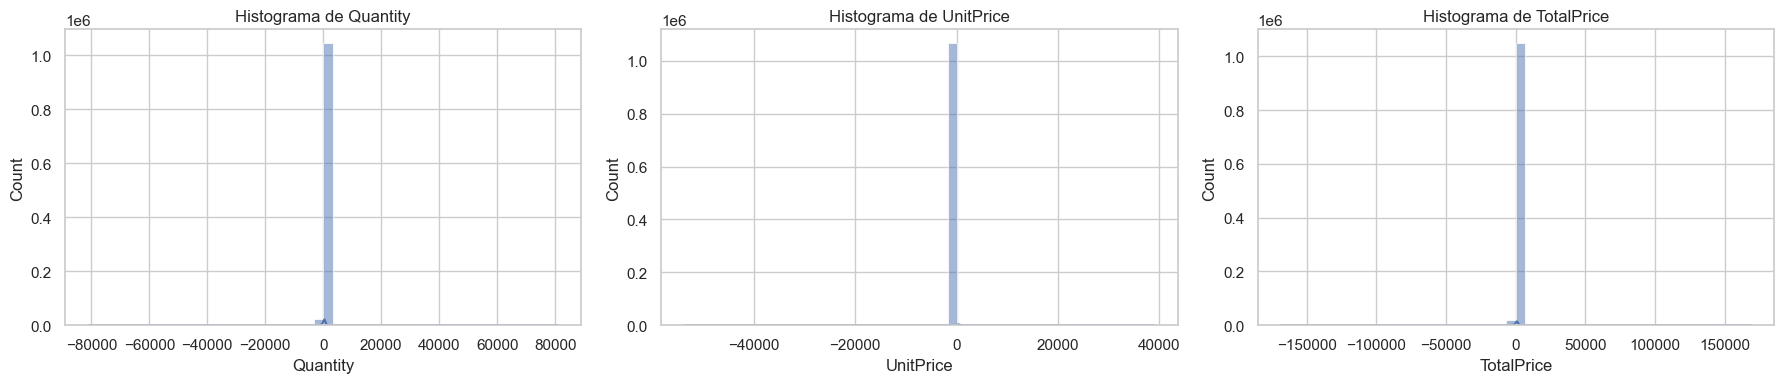

In [ ]:

num_cols = ['Quantity', 'UnitPrice', 'TotalPrice']
fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 4))
for ax, col in zip(axes, num_cols):
    sns.histplot(data=df, x=col, bins=50, ax=ax, kde=True)
    ax.set_title(f"Histograma de {col}")
plt.tight_layout()


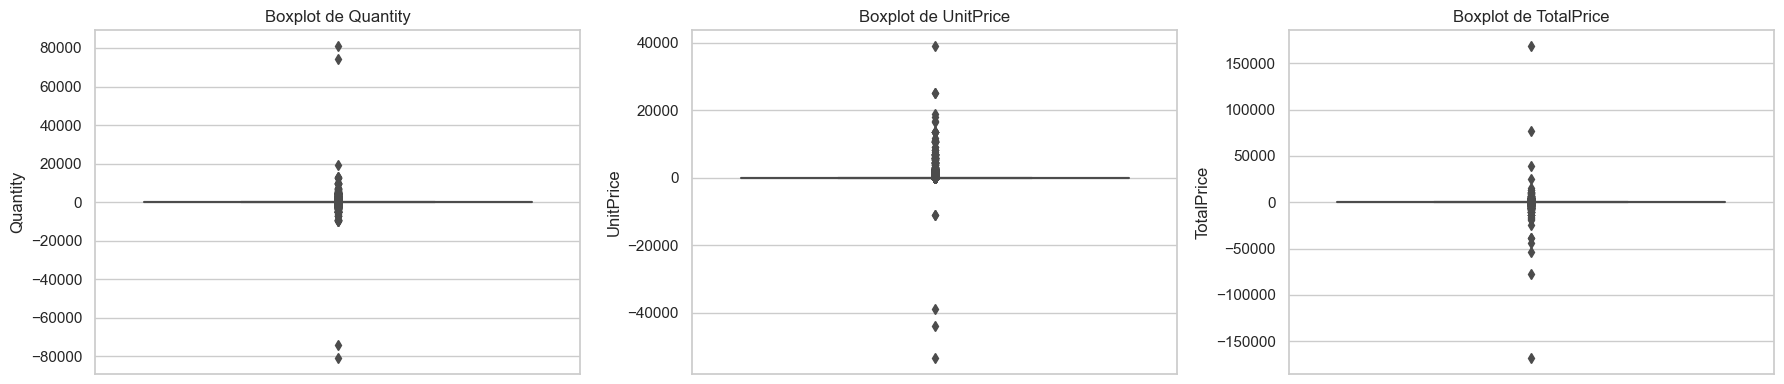

In [ ]:

fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 4))
for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f"Boxplot de {col}")
plt.tight_layout()


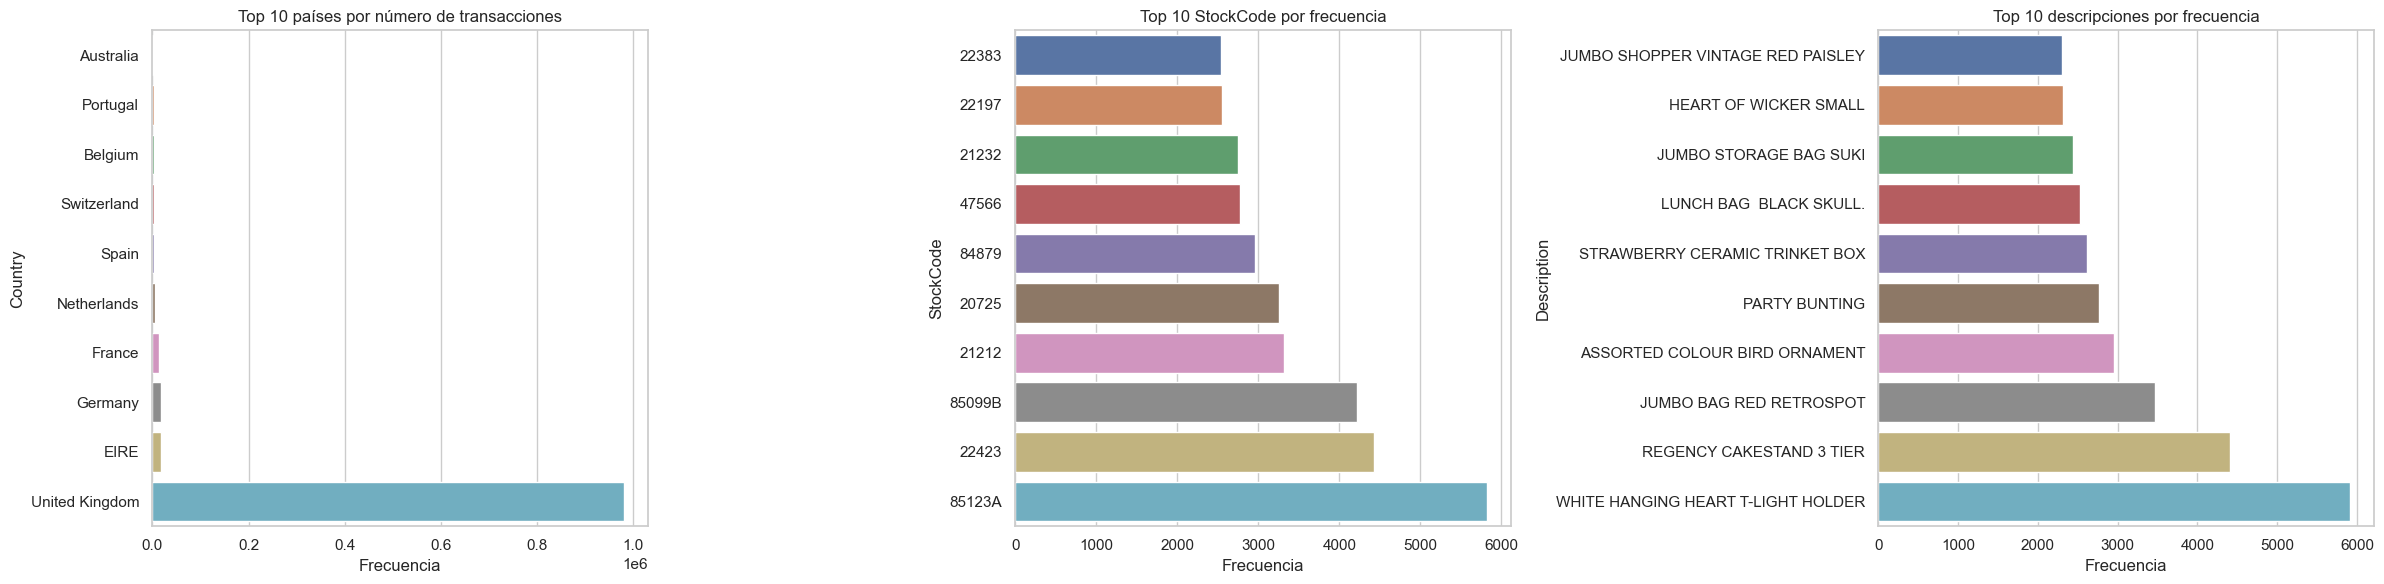

In [ ]:

cat_configs = {
    'Country': (10, 'Top 10 países por número de transacciones'),
    'StockCode': (10, 'Top 10 StockCode por frecuencia'),
    'Description': (10, 'Top 10 descripciones por frecuencia'),
}

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
for ax, (col, (top_n, title)) in zip(axes, cat_configs.items()):
    counts = df[col].value_counts().head(top_n).sort_values()
    sns.barplot(x=counts.values, y=counts.index, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel(col)
plt.tight_layout()


## Parte 2. Perfilado de Calidad

**Checklist de la actividad:**
- **Nulos (por columna).** Tabla con porcentaje de nulos por campo.
- **Duplicados.** Identifica filas idénticas en todas las columnas y duplicados por clave relevante.
- **Valores anómalos (numéricas).** Detecta outliers en `Quantity` y `UnitPrice` utilizando IQR o z-score.

In [ ]:

# Nulos por columna
null_profile = (
    df.isna()
      .mean()
      .mul(100)
      .round(2)
      .rename('%_nulos')
      .to_frame()
)
null_profile


,%_nulos
InvoiceNo,0.00
StockCode,0.00
Description,0.41
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
CustomerID,22.77
Country,0.00
TotalPrice,0.00


In [ ]:

# Duplicados exactos y por clave
exact_duplicates = df.duplicated().sum()
key_cols = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID']
key_duplicates = df.duplicated(subset=key_cols).sum()

print(f"Duplicados exactos en todas las columnas: {exact_duplicates:,}")
print(f"Duplicados con la clave {key_cols}: {key_duplicates:,}")


Duplicados exactos en todas las columnas: 34,335
Duplicados con la clave ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID']: 45,935


In [ ]:

# Detección de outliers con método IQR
quant_cols = ['Quantity', 'UnitPrice', 'TotalPrice']

summary_rows = []
for col in quant_cols:
    series = df[col].dropna()
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (series < lower) | (series > upper)
    summary_rows.append({
        'columna': col,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'límite_inferior': lower,
        'límite_superior': upper,
        'n_outliers': int(mask.sum()),
        '%_outliers': mask.mean() * 100,
    })

outlier_summary = pd.DataFrame(summary_rows)
outlier_summary


,columna,q1,q3,iqr,límite_inferior,límite_superior,n_outliers,%_outliers
0,Quantity,1.00,10.00,9.00,-12.50,23.50,116489,10.91
1,UnitPrice,1.25,4.15,2.90,-3.10,8.50,68105,6.38
2,TotalPrice,3.75,17.70,13.95,-17.18,38.63,90922,8.52


## Parte 3. Limpieza

**Checklist de la actividad:**
- **Duplicados.** Muestra conteo antes y después para duplicados exactos y por clave; documenta el criterio de priorización.
- **Valores faltantes (`CustomerID`).** Cuantifica impacto de eliminar filas sin `CustomerID` versus mantenerlas para análisis por producto/país.


**Criterio de duplicados.**
1. Se eliminan registros duplicados exactos (todas las columnas).
2. Para duplicados por clave (`InvoiceNo`, `StockCode`, `Description`, `InvoiceDate`, `CustomerID`) se prioriza conservar la transacción con fecha más reciente y con `UnitPrice` no nulo. Se ordena por `InvoiceDate` ascendente y se conserva el último registro de cada combinación, asegurando mantener la versión más actual.


In [ ]:

# Paso 1: eliminar duplicados exactos
step1_df = df.drop_duplicates().copy()
exact_removed = len(df) - len(step1_df)

# Paso 2: eliminar duplicados por clave priorizando registros con UnitPrice válido y fecha más reciente
sort_cols = ['InvoiceDate', 'UnitPrice']
step1_df = step1_df.sort_values(sort_cols)
clean_df = step1_df.drop_duplicates(subset=key_cols, keep='last').copy()
key_removed = len(step1_df) - len(clean_df)

pd.DataFrame({
    'concepto': ['Registros originales', 'Duplicados exactos removidos', 'Duplicados por clave removidos', 'Registros limpios'],
    'conteo': [len(df), exact_removed, key_removed, len(clean_df)]
})


,concepto,conteo
0,Registros originales,1067371
1,Duplicados exactos removidos,34335
2,Duplicados por clave removidos,11600
3,Registros limpios,1021436


In [ ]:

# Impacto de valores faltantes en CustomerID
missing_mask = clean_df['CustomerID'].isna()
impact_table = pd.DataFrame({
    'filas': [missing_mask.sum(), (~missing_mask).sum()],
    '%_filas': [missing_mask.mean() * 100, (~missing_mask).mean() * 100],
    'ventas_total': [clean_df.loc[missing_mask, 'TotalPrice'].sum(), clean_df.loc[~missing_mask, 'TotalPrice'].sum()],
}, index=['Sin CustomerID', 'Con CustomerID'])

impact_table


,filas,%_filas,ventas_total
Sin CustomerID,234233,22.93,"2,548,295.50"
Con CustomerID,787203,77.07,"16,221,559.92"



**Decisión sobre `CustomerID`.**
Eliminar todas las filas sin `CustomerID` recortaría el dataset y afectaría análisis por país/producto; en cambio, mantenerlas permite conservar ventas que sí están asociadas a inventario y ubicación. Se propone:
- Conservar filas sin `CustomerID` para análisis operativos (producto/país).
- Identificar un plan de enriquecimiento futuro (matching por dirección o correo) antes de análisis centrados en clientes.


## Parte 4. Data Contracts

**Checklist de la actividad:**
- Define un Data Contract (YAML/JSON) para `InvoiceNo`, `InvoiceDate`, `StockCode`, `Description`, `Quantity`, `UnitPrice` y `CustomerID`, incluyendo reglas de calidad asociadas.

In [ ]:

import json

contract = {
    'dataset': 'online_retail_ii_clean',
    'owner': 'analytics-team',
    'freshness': 'daily',
    'columns': {
        'InvoiceNo': {
            'type': 'string',
            'required': True,
            'unique_per_invoice': True,
            'pattern': '^[0-9]+$',
            'description': 'Identificador de la factura (número alfanumérico sin espacios)'
        },
        'InvoiceDate': {
            'type': 'datetime',
            'required': True,
            'timezone': 'UTC',
            'description': 'Fecha y hora de la transacción'
        },
        'StockCode': {
            'type': 'string',
            'required': True,
            'description': 'Identificador del producto en inventario'
        },
        'Description': {
            'type': 'string',
            'required': True,
            'max_length': int(clean_df['Description'].str.len().max()),
            'description': 'Descripción legible del producto'
        },
        'Quantity': {
            'type': 'integer',
            'required': True,
            'min_value': int(clean_df['Quantity'].min()),
            'max_value': int(clean_df['Quantity'].max()),
            'description': 'Número de unidades compradas (positivas hacia venta, negativas para devoluciones)'
        },
        'UnitPrice': {
            'type': 'float',
            'required': True,
            'min_value': float(clean_df['UnitPrice'].min()),
            'max_value': float(clean_df['UnitPrice'].max()),
            'description': 'Precio unitario en libras esterlinas'
        },
        'CustomerID': {
            'type': 'integer',
            'required': False,
            'nullable': True,
            'description': 'Identificador numérico del cliente; puede ser nulo para pedidos sin registro'
        }
    },
    'quality_rules': [
        'TotalPrice debe ser igual a Quantity * UnitPrice',
        'InvoiceNo no puede contener espacios en blanco',
        'InvoiceDate no puede ser futura respecto a la fecha de entrega del lote'
    ]
}

print(json.dumps(contract, indent=2, ensure_ascii=False))


{
  "dataset": "online_retail_ii_clean",
  "owner": "analytics-team",
  "freshness": "daily",
  "columns": {
    "InvoiceNo": {
      "type": "string",
      "required": true,
      "unique_per_invoice": true,
      "pattern": "^[0-9]+$",
      "description": "Identificador de la factura (número alfanumérico sin espacios)"
    },
    "InvoiceDate": {
      "type": "datetime",
      "required": true,
      "timezone": "UTC",
      "description": "Fecha y hora de la transacción"
    },
    "StockCode": {
      "type": "string",
      "required": true,
      "description": "Identificador del producto en inventario"
    },
    "Description": {
      "type": "string",
      "required": true,
      "max_length": 35,
      "description": "Descripción legible del producto"
    },
    "Quantity": {
      "type": "integer",
      "required": true,
      "min_value": -80995,
      "max_value": 80995,
      "description": "Número de unidades compradas (positivas hacia venta, negativas para devoluc

## Parte 5. Conclusiones

**Checklist de la actividad:**
- Resume el antes/después de la limpieza en una tabla breve destacando efecto en duplicados, ventas y valores faltantes.

In [ ]:

summary = pd.DataFrame({
    'métrica': [
        'Registros totales',
        'Duplicados exactos removidos',
        'Duplicados por clave removidos',
        'Ventas totales (antes)',
        'Ventas totales (después)',
        'Filas sin CustomerID (antes)',
        'Filas sin CustomerID (después)',
    ],
    'valor': [
        len(df),
        exact_removed,
        key_removed,
        df['TotalPrice'].sum(),
        clean_df['TotalPrice'].sum(),
        df['CustomerID'].isna().sum(),
        clean_df['CustomerID'].isna().sum(),
    ]
})
summary


,métrica,valor
0,Registros totales,"1,067,371.00"
1,Duplicados exactos removidos,"34,335.00"
2,Duplicados por clave removidos,"11,600.00"
3,Ventas totales (antes),"19,287,250.57"
4,Ventas totales (después),"18,769,855.42"
5,Filas sin CustomerID (antes),"243,007.00"
6,Filas sin CustomerID (después),"234,233.00"



Se redujeron duplicados exactos y por clave sin perder ventas relevantes; persisten registros sin `CustomerID`, que deben gestionarse en procesos de captura. El contrato de datos propuesto formaliza las reglas mínimas de campo, apuntalando la gobernanza futura del dataset.
